In [1]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [2]:
import pandas as pd
PRIMARY = 'Category Name'
SECONDARY = 'Order Region'

df = pd.read_csv(
    'DataCoSupplyChainDataset.csv', 
    usecols = [PRIMARY, SECONDARY], 
    encoding = 'unicode_escape'
).apply(lambda col: col.str.strip())
df.head()

,Category Name,Order Region
0,Sporting Goods,Southeast Asia
1,Sporting Goods,South Asia
2,Sporting Goods,South Asia
3,Sporting Goods,Oceania
4,Sporting Goods,Oceania


# Check & remove null + duplicate values

In [3]:
df.isnull().sum().sort_values(ascending=False)

Category Name    0
Order Region     0
dtype: int64

In [4]:
df.drop_duplicates(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 691 entries, 0 to 162002
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Category Name  691 non-null    object
 1   Order Region   691 non-null    object
dtypes: object(2)
memory usage: 16.2+ KB


# Convert DataFrame to Graphs

In [5]:
primary_col, secondary_col = df[PRIMARY], df[SECONDARY]
print(f'Number of {PRIMARY}:', primary_col.nunique())
print(f'Number of {SECONDARY}:', secondary_col.nunique())
print('Number of edges:', len(df))

Number of Category Name: 50
Number of Order Region: 23
Number of edges: 691


## 1. Bipartite Graph

In [6]:
import networkx as nx
from networkx.algorithms import bipartite

B = nx.Graph()
for index, row in df.iterrows():
    B.add_edge(row[PRIMARY], row[SECONDARY], weight=1)

B.add_nodes_from(primary_col, bipartite=0)
B.add_nodes_from(secondary_col, bipartite=1)    

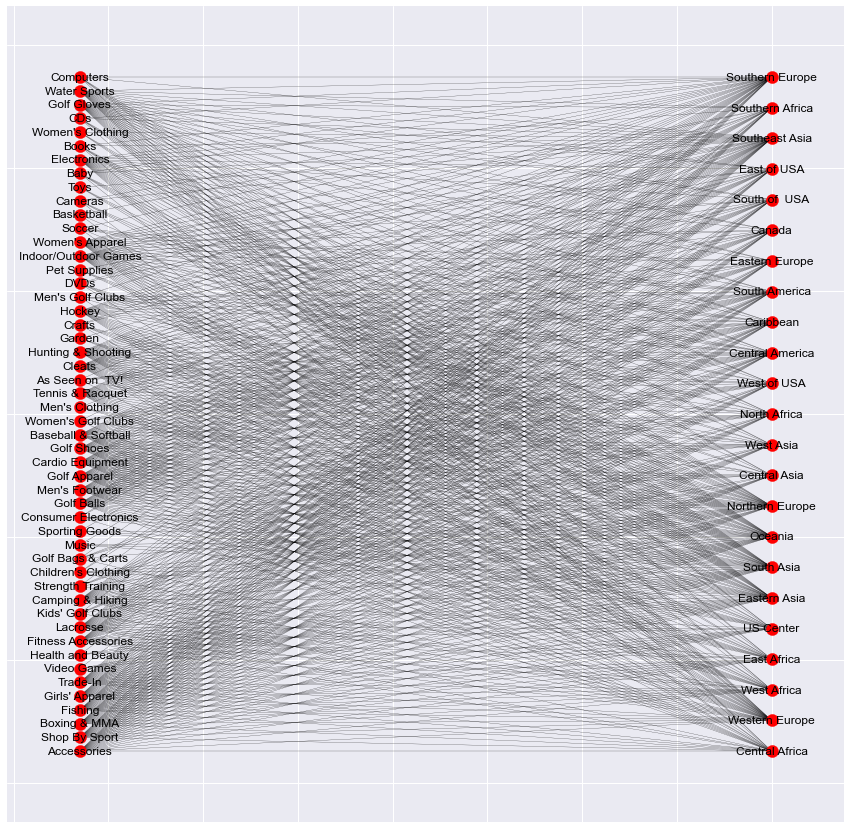

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 15))
pos = nx.drawing.layout.bipartite_layout(B, primary_col)
nx.draw_networkx(B, pos=pos, node_size=150, width=0.2, node_color='red')

## 2. Weighted Projected Graph

In [8]:
G = bipartite.weighted_projected_graph(B, primary_col)
node_labels = dict(zip(primary_col, primary_col))

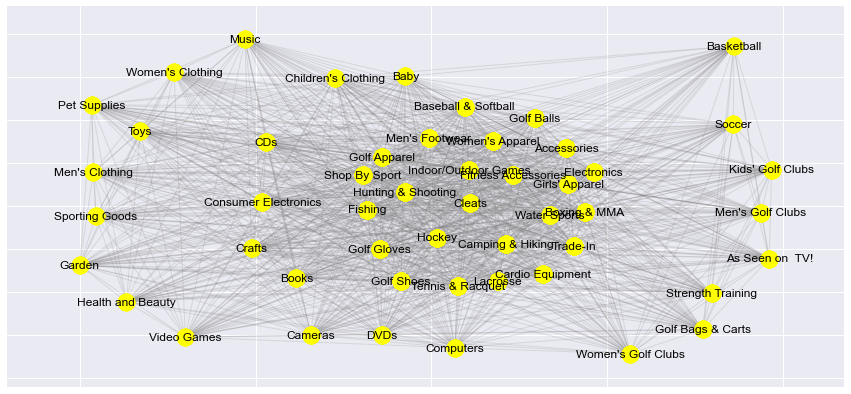

In [9]:
plt.figure(figsize=(15, 7))
pos = nx.spring_layout(G)

nx.draw_networkx_nodes(G, pos, nodelist=primary_col, node_color='yellow')
nx.draw_networkx_edges(G, pos, edge_color='grey', alpha=0.2)
nx.draw_networkx_labels(G, pos, labels=node_labels)
plt.show()

# Community Detection

In [10]:
df_groupby_category = df.groupby([SECONDARY])[PRIMARY].apply(lambda x: sorted(set(x)))
df_groupby_category = df_groupby_category.reset_index()
# print(df_groupby_category.iloc[14][1])
df_groupby_category.head()

,Order Region,Category Name
0,Canada,"[Accessories, Baseball & Softball, Boxing & MM..."
1,Caribbean,"[Accessories, As Seen on TV!, Baseball & Soft..."
2,Central Africa,"[Accessories, Baseball & Softball, Boxing & MM..."
3,Central America,"[Accessories, As Seen on TV!, Baseball & Soft..."
4,Central Asia,"[Accessories, Boxing & MMA, Camping & Hiking, ..."


In [11]:
def get_cluster_common_values(cluster):
    commons = []
    for index, row in df_groupby_category.iterrows():
        if set(cluster).issubset(row[PRIMARY]):
            commons.append(row[SECONDARY])
    return commons

In [12]:
def print_communities(node_groups):
    print('Number of communities:', len(node_groups))
    for index, cluster in enumerate(node_groups):
        common_values = get_cluster_common_values(cluster)
        print(f'\nCluster {index}:')
        print(f"- {len(cluster)} Nodes: {', '.join(cluster)}")
        print(f"- {len(common_values)} Common values: {', '.join(common_values)}")

## 1. Louvain Algorithm

In [13]:
import community.community_louvain as community_louvain
from collections import defaultdict
partition = community_louvain.best_partition(G)
louvain_node_groups = [[] for _ in set(partition.values())]

for node, cluster in sorted(partition.items()):
    louvain_node_groups[cluster].append(node)
print_communities(louvain_node_groups)

Number of communities: 3

Cluster 0:
- 18 Nodes: Baby, Books, CDs, Cameras, Children's Clothing, Computers, Consumer Electronics, Crafts, DVDs, Garden, Health and Beauty, Men's Clothing, Music, Pet Supplies, Sporting Goods, Toys, Video Games, Women's Clothing
- 3 Common values: Oceania, South Asia, Southeast Asia

Cluster 1:
- 8 Nodes: As Seen on  TV!, Basketball, Golf Bags & Carts, Kids' Golf Clubs, Men's Golf Clubs, Soccer, Strength Training, Women's Golf Clubs
- 3 Common values: Northern Europe, Southern Europe, Western Europe

Cluster 2:
- 24 Nodes: Accessories, Baseball & Softball, Boxing & MMA, Camping & Hiking, Cardio Equipment, Cleats, Electronics, Fishing, Fitness Accessories, Girls' Apparel, Golf Apparel, Golf Balls, Golf Gloves, Golf Shoes, Hockey, Hunting & Shooting, Indoor/Outdoor Games, Lacrosse, Men's Footwear, Shop By Sport, Tennis & Racquet, Trade-In, Water Sports, Women's Apparel
- 22 Common values: Canada, Caribbean, Central Africa, Central America, East Africa, East

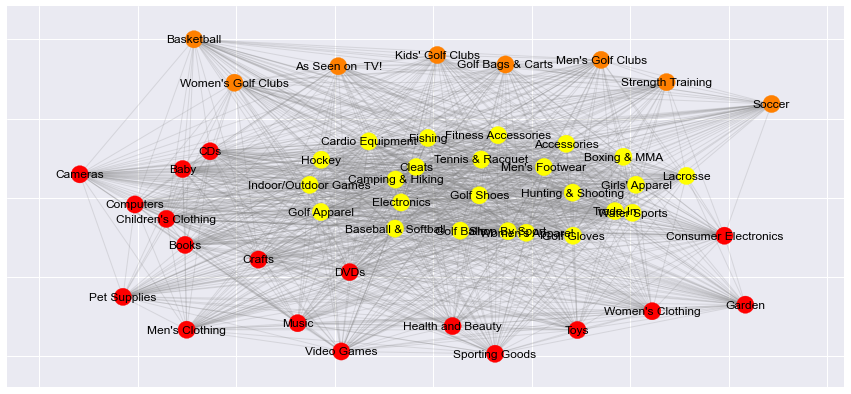

In [14]:
import matplotlib.cm as cm
cmap = cm.get_cmap('autumn', max(partition.values()) + 1)
pos = nx.spring_layout(G)

plt.figure(figsize=(15, 7))
nx.draw_networkx_nodes(G, pos, partition.keys(), cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, edge_color='grey', alpha=0.2)
nx.draw_networkx_labels(G, pos)
plt.show()

## 2. K-Means Algorithm

In [15]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
adj_matrix = nx.to_numpy_array(G)
adj_matrix

array([[ 0.,  4.,  4., ...,  4.,  4.,  4.],
       [ 4.,  0., 23., ...,  4., 23., 23.],
       [ 4., 23.,  0., ...,  4., 23., 23.],
       ...,
       [ 4.,  4.,  4., ...,  0.,  4.,  4.],
       [ 4., 23., 23., ...,  4.,  0., 23.],
       [ 4., 23., 23., ...,  4., 23.,  0.]])

In [16]:
import numpy as np
distortions = []
K = range(1, 8)

for k in K:
    kmean_model = KMeans(n_clusters=k)
    kmean_model.fit(adj_matrix)
    dist = sum(np.min(cdist(adj_matrix, kmean_model.cluster_centers_, 'euclidean'), axis=1))
    distortions.append(dist / adj_matrix.shape[0])

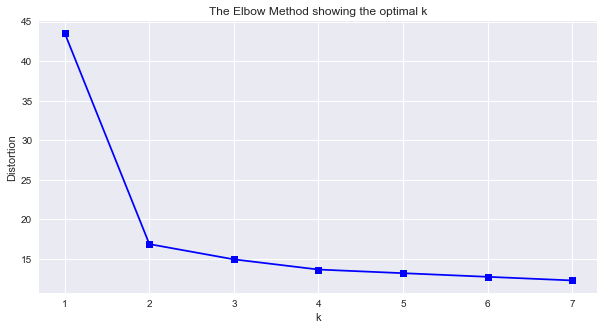

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(K, distortions, 'bs-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [18]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(adj_matrix)
kmeans_node_groups = [[] for _ in range(kmeans.n_clusters)]
 
for node, cluster in zip(G.nodes(), kmeans.labels_):
    kmeans_node_groups[cluster].append(node)
print_communities(kmeans_node_groups)

Number of communities: 2

Cluster 0:
- 26 Nodes: Sporting Goods, Kids' Golf Clubs, Consumer Electronics, Cameras, Computers, Basketball, Soccer, Women's Clothing, Crafts, Men's Clothing, As Seen on  TV!, Strength Training, Children's Clothing, Baby, Books, DVDs, CDs, Garden, Pet Supplies, Health and Beauty, Music, Video Games, Golf Bags & Carts, Women's Golf Clubs, Men's Golf Clubs, Toys
- 0 Common values: 

Cluster 1:
- 24 Nodes: Cleats, Shop By Sport, Women's Apparel, Electronics, Boxing & MMA, Cardio Equipment, Trade-In, Hunting & Shooting, Baseball & Softball, Men's Footwear, Camping & Hiking, Girls' Apparel, Accessories, Tennis & Racquet, Fitness Accessories, Golf Balls, Lacrosse, Fishing, Hockey, Golf Gloves, Golf Shoes, Golf Apparel, Water Sports, Indoor/Outdoor Games
- 22 Common values: Canada, Caribbean, Central Africa, Central America, East Africa, East of USA, Eastern Asia, Eastern Europe, North Africa, Northern Europe, Oceania, South America, South Asia, South of  USA, Sout

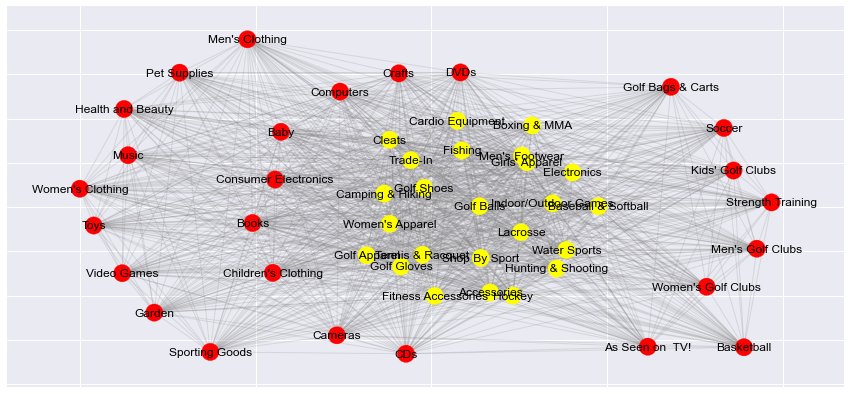

In [19]:
cmap = cm.get_cmap('autumn', max(kmeans.labels_) + 1)
pos = nx.spring_layout(G)

plt.figure(figsize=(15, 7))
nx.draw_networkx_nodes(G, pos, G.nodes(), cmap=cmap, node_color=kmeans.labels_)
nx.draw_networkx_edges(G, pos, edge_color='grey', alpha=0.2)
nx.draw_networkx_labels(G, pos)
plt.show()

## 3. Gaussian Mixture Model

In [35]:
from sklearn.mixture import GaussianMixture
n_clusters = 3
gmm = GaussianMixture(n_components=n_clusters)
gmm.fit(adj_matrix)

labels = gmm.predict(adj_matrix)
gmm_node_groups = [[] for _ in range(n_clusters)]

for node, cluster in zip(G.nodes(), labels):
    gmm_node_groups[cluster].append(node)
print_communities(gmm_node_groups)

Number of communities: 3

Cluster 0:
- 18 Nodes: Sporting Goods, Consumer Electronics, Cameras, Computers, Women's Clothing, Crafts, Men's Clothing, Children's Clothing, Baby, Books, DVDs, CDs, Garden, Pet Supplies, Health and Beauty, Music, Video Games, Toys
- 3 Common values: Oceania, South Asia, Southeast Asia

Cluster 1:
- 24 Nodes: Cleats, Shop By Sport, Women's Apparel, Electronics, Boxing & MMA, Cardio Equipment, Trade-In, Hunting & Shooting, Baseball & Softball, Men's Footwear, Camping & Hiking, Girls' Apparel, Accessories, Tennis & Racquet, Fitness Accessories, Golf Balls, Lacrosse, Fishing, Hockey, Golf Gloves, Golf Shoes, Golf Apparel, Water Sports, Indoor/Outdoor Games
- 22 Common values: Canada, Caribbean, Central Africa, Central America, East Africa, East of USA, Eastern Asia, Eastern Europe, North Africa, Northern Europe, Oceania, South America, South Asia, South of  USA, Southeast Asia, Southern Africa, Southern Europe, US Center, West Africa, West Asia, West of USA, We

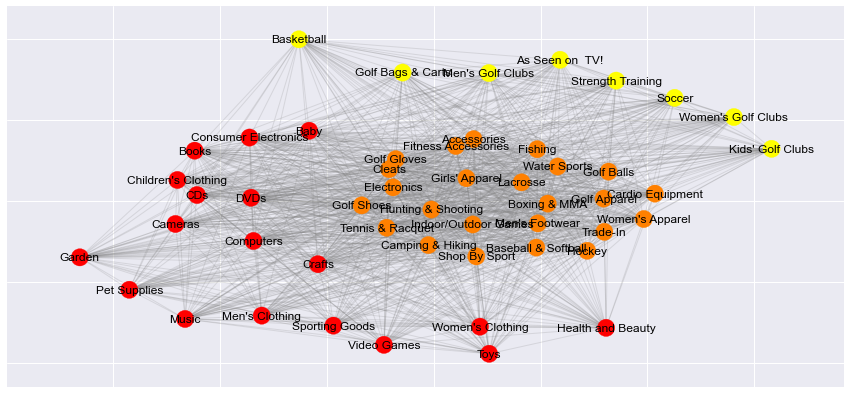

In [36]:
cmap = cm.get_cmap('autumn', max(labels) + 1)
pos = nx.spring_layout(G)

plt.figure(figsize=(15, 7))
nx.draw_networkx_nodes(G, pos, G.nodes(), cmap=cmap, node_color=labels)
nx.draw_networkx_edges(G, pos, edge_color='grey', alpha=0.2)
nx.draw_networkx_labels(G, pos)
plt.show()

# Network Centrality

In [37]:
def print_centrality(centrality, name):
    result = pd.DataFrame(centrality, columns=['Category Name', name])
    result.sort_values(name, ascending=False, inplace=True)
    print(result.to_records(index=False).tolist())
    return result

In [38]:
# Degree Centrality
degree = nx.degree(G)
print_centrality(degree, 'Degree').head()

[('Indoor/Outdoor Games', 49), ('Golf Balls', 49), ('Golf Shoes', 49), ('Crafts', 49), ('Golf Gloves', 49), ('Tennis & Racquet', 49), ('Fitness Accessories', 49), ('Cleats', 49), ("Children's Clothing", 49), ('Golf Apparel', 49), ('Lacrosse', 49), ('Baby', 49), ('Fishing', 49), ('Books', 49), ('DVDs', 49), ('CDs', 49), ('Accessories', 49), ("Girls' Apparel", 49), ('Hockey', 49), ('Shop By Sport', 49), ('Computers', 49), ('Cameras', 49), ('Consumer Electronics', 49), ('Camping & Hiking', 49), ("Men's Footwear", 49), ('Baseball & Softball', 49), ('Hunting & Shooting', 49), ('Water Sports', 49), ('Trade-In', 49), ('Cardio Equipment', 49), ('Boxing & MMA', 49), ('Electronics', 49), ("Women's Apparel", 49), ('Music', 41), ('Health and Beauty', 41), ('Toys', 41), ('Video Games', 41), ('Sporting Goods', 41), ('Pet Supplies', 41), ('Garden', 41), ("Men's Clothing", 41), ("Women's Clothing", 41), ('Strength Training', 40), ('Golf Bags & Carts', 40), ('Soccer', 40), ("Women's Golf Clubs", 40), (

,Category Name,Degree
49,Indoor/Outdoor Games,49
26,Golf Balls,49
43,Golf Shoes,49
21,Crafts,49
41,Golf Gloves,49


In [39]:
# Betweenness Centrality
betweenness = nx.betweenness_centrality(G)
print_centrality(betweenness.items(), 'Betweenness Centrality').head()

[('Indoor/Outdoor Games', 0.0018552875695732828), ("Girls' Apparel", 0.0018552875695732828), ('Golf Apparel', 0.0018552875695732828), ('Tennis & Racquet', 0.0018552875695732828), ('Fitness Accessories', 0.0018552875695732828), ('Cleats', 0.0018552875695732828), ('Golf Balls', 0.0018552875695732828), ('Golf Shoes', 0.0018552875695732828), ("Children's Clothing", 0.0018552875695732828), ('Lacrosse', 0.0018552875695732828), ('Baby', 0.0018552875695732828), ('Fishing', 0.0018552875695732828), ('Books', 0.0018552875695732828), ('DVDs', 0.0018552875695732828), ('CDs', 0.0018552875695732828), ('Hockey', 0.0018552875695732828), ('Golf Gloves', 0.0018552875695732828), ('Crafts', 0.0018552875695732828), ('Accessories', 0.0018552875695732828), ('Hunting & Shooting', 0.0018552875695732828), ('Electronics', 0.0018552875695732828), ('Shop By Sport', 0.0018552875695732828), ("Women's Apparel", 0.0018552875695732828), ('Computers', 0.0018552875695732828), ('Cameras', 0.0018552875695732828), ('Consumer

,Category Name,Betweenness Centrality
49,Indoor/Outdoor Games,0.001855
18,Girls' Apparel,0.001855
44,Golf Apparel,0.001855
23,Tennis & Racquet,0.001855
24,Fitness Accessories,0.001855


In [40]:
# Closeness Centrality
closeness = nx.closeness_centrality(G)
print_centrality(closeness.items(), 'Closeness Centrality').head()

[('Indoor/Outdoor Games', 1.0), ('Golf Balls', 1.0), ('Golf Shoes', 1.0), ('Crafts', 1.0), ('Golf Gloves', 1.0), ('Tennis & Racquet', 1.0), ('Fitness Accessories', 1.0), ('Cleats', 1.0), ("Children's Clothing", 1.0), ('Golf Apparel', 1.0), ('Lacrosse', 1.0), ('Baby', 1.0), ('Fishing', 1.0), ('Books', 1.0), ('DVDs', 1.0), ('CDs', 1.0), ('Accessories', 1.0), ("Girls' Apparel", 1.0), ('Hockey', 1.0), ('Shop By Sport', 1.0), ('Computers', 1.0), ('Cameras', 1.0), ('Consumer Electronics', 1.0), ('Camping & Hiking', 1.0), ("Men's Footwear", 1.0), ('Baseball & Softball', 1.0), ('Hunting & Shooting', 1.0), ('Water Sports', 1.0), ('Trade-In', 1.0), ('Cardio Equipment', 1.0), ('Boxing & MMA', 1.0), ('Electronics', 1.0), ("Women's Apparel", 1.0), ('Music', 0.8596491228070176), ('Health and Beauty', 0.8596491228070176), ('Toys', 0.8596491228070176), ('Video Games', 0.8596491228070176), ('Sporting Goods', 0.8596491228070176), ('Pet Supplies', 0.8596491228070176), ('Garden', 0.8596491228070176), ("Me

,Category Name,Closeness Centrality
49,Indoor/Outdoor Games,1.0
26,Golf Balls,1.0
43,Golf Shoes,1.0
21,Crafts,1.0
41,Golf Gloves,1.0


In [41]:
# Eigenvector Centrality
eigenvector = nx.eigenvector_centrality(G)
print_centrality(eigenvector.items(), 'Eigenvector Centrality').head()

[('Indoor/Outdoor Games', 0.14867064721396608), ("Children's Clothing", 0.14867064721396608), ('Crafts', 0.14867064721396608), ('Golf Gloves', 0.14867064721396608), ('Tennis & Racquet', 0.14867064721396608), ('Fitness Accessories', 0.14867064721396608), ('Cleats', 0.14867064721396608), ('Golf Balls', 0.14867064721396608), ('Lacrosse', 0.14867064721396608), ("Girls' Apparel", 0.14867064721396608), ('Baby', 0.14867064721396608), ('Fishing', 0.14867064721396608), ('Books', 0.14867064721396608), ('DVDs', 0.14867064721396608), ('CDs', 0.14867064721396608), ('Hockey', 0.14867064721396608), ('Golf Shoes', 0.14867064721396608), ('Accessories', 0.14867064721396608), ('Golf Apparel', 0.14867064721396608), ('Water Sports', 0.14867064721396608), ('Shop By Sport', 0.14867064721396608), ("Women's Apparel", 0.14867064721396608), ('Electronics', 0.14867064721396608), ('Boxing & MMA', 0.14867064721396608), ('Cardio Equipment', 0.14867064721396608), ('Trade-In', 0.14867064721396608), ('Hunting & Shootin

,Category Name,Eigenvector Centrality
49,Indoor/Outdoor Games,0.148671
28,Children's Clothing,0.148671
21,Crafts,0.148671
41,Golf Gloves,0.148671
23,Tennis & Racquet,0.148671


In [42]:
# PageRank
pagerank = nx.pagerank(G)
print_centrality(pagerank.items(), 'PageRank').head()

[('Indoor/Outdoor Games', 0.02910004330793566), ("Men's Footwear", 0.02910004330793566), ('Fishing', 0.02910004330793566), ('Lacrosse', 0.02910004330793566), ('Golf Balls', 0.02910004330793566), ('Cleats', 0.02910004330793566), ('Tennis & Racquet', 0.02910004330793566), ('Golf Apparel', 0.02910004330793566), ('Accessories', 0.02910004330793566), ('Camping & Hiking', 0.02910004330793566), ("Girls' Apparel", 0.02910004330793566), ('Cardio Equipment', 0.02910004330793566), ('Water Sports', 0.02910004330793566), ('Shop By Sport', 0.02910004330793566), ("Women's Apparel", 0.02910004330793566), ('Electronics', 0.02910004330793566), ('Boxing & MMA', 0.02910004330793566), ('Hunting & Shooting', 0.02910004330793566), ('Trade-In', 0.02910004330793566), ('Golf Gloves', 0.02910004330793566), ('Hockey', 0.028393028110741375), ('Golf Shoes', 0.028393028110741375), ('Fitness Accessories', 0.028393028110741375), ('Baseball & Softball', 0.028393028110741375), ('Crafts', 0.01460032971973412), ('Computer

,Category Name,PageRank
49,Indoor/Outdoor Games,0.0291
11,Men's Footwear,0.0291
31,Fishing,0.0291
29,Lacrosse,0.0291
26,Golf Balls,0.0291
